<a href="https://colab.research.google.com/github/Chang365/ESAA-25-1-assignments/blob/main/ESAA_25_2_1006_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이썬 머신러닝 완벽 가이드 개정 2판 8장 p.566-583

# 10 텍스트 분석 실습 — 캐글 Mercari Price Suggestion Challenge



## 데이터 전처리

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
mercari_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


- 1482535개의 레코드를 가지고 있는 데이터 세트

In [7]:
# 피처의 타입과 NULL 여부 확인
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- brand_name 칼럼의 경우 매우 많은 Null 값
- category_name은 악= 6300건의 null 데이터
- item_desciption의 null 값은 4건으로 미비

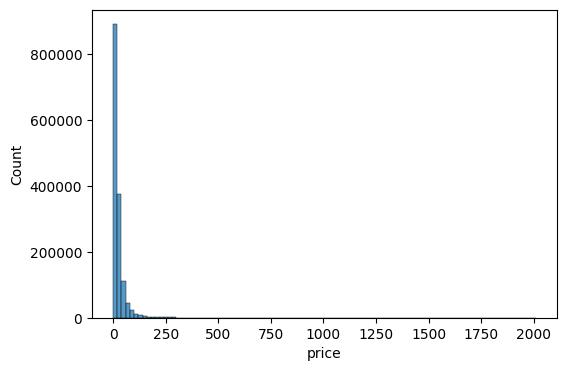

In [8]:
# Price 칼럼 (타켓값) 데이터 분포도
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

- price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포 -> 로그값 변환

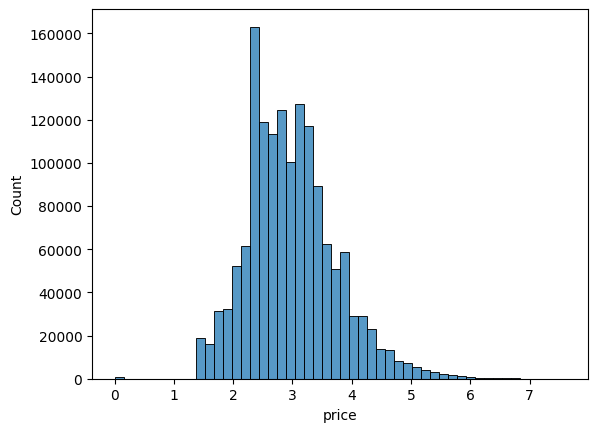

In [9]:
# 로그값 변환
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

- 정규분포 가까움

In [10]:
# price 칼럼을 원래 값에서 로그로 변환된 값으로 변경

mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [11]:
# shipping과 item_condition_id 값의 유형
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형:
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


- Shipping 칼럼은 배송비 유무이며, 값이 비교적 균일
- Item_condition_id는 판매자가 제공하
는 제품 상태로서 1, 2, 3 값
- item_description 칼럼은 Null 값은 별로 없지만, description에 대한 별도 설명이 없는 경우 ‘No description yet’ 값으로 되어있음

In [12]:
# No description yet 얼마나?
boolen_cond = mercari_df['item_description'] == 'No description yet'
print(boolen_cond.sum())

82489


- 82489건이며, Null과 마찬가지이므로 적절한 값으로 변경해야 함

- category_name의 /를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습
- category_name 칼럼을 /를 기준으로 대, 중, 소분류를 효과적으로 분리해 내기 위해 별도의 split_cat() 함수를 생성하고 이를 DataFrame의 apply lambda 식에 적용

In [13]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수:', mercari_df['cat_jung'].nunique())
print('소분류 개수:', mercari_df['cat_so'].nunique())

대분류 유형:
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 개수: 114
소분류 개수: 871


In [14]:
# brand_name, category name, item_description 칼럼의 Null 값은 일괄적으로 'Other Null'로 변경
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 함
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


## 피처 인코딩과 피처 벡터화

- 선형 회귀 모델과 회귀 트리 모델을 모두 적용
- 선형 회귀의 경우 원-핫 인코딩
- 피처
벡터화의 경우는 비교적 짧은 텍스트의 경우는 Count 기반의 벡터화를, 긴 텍스트는 TD-IDF 기반 벡터화


In [15]:
# brand_name

print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print(mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: 4810
brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


- 대부분 문자열 -> 별도의 피처 벡터화 형태 만들 필요 없이 인코딩 변환


In [16]:
# name

print('name의 종류 개수:', mercari_df['name'].nunique())
print('name sample 7건:\n', mercari_df['name'][:7])

name의 종류 개수: 1225273
name sample 7건:
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


- 종류 1,225,273가지
- Count 기반으로 피처 벡터화 변환
- cat_dae, catjung, cat_so 칼럼도 원핫 인코딩

- shipping, item_condotion_id -> 원핫인코딩

In [17]:
#  item_decription
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 오차열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 오차열 크기: 145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


- 평균 문자열이 145자로 비교적 큼. -> TH-IDF 변

In [18]:
# 주요 칼럼 인코딩 및 피처 벡터화 변환
# name -> CountVectorizer
# item_description -> TfidfVectorizer

# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


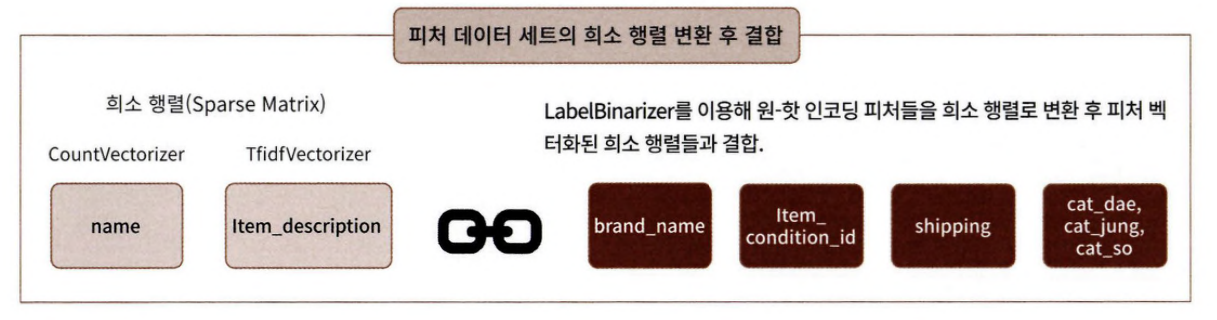

In [19]:
# 인코딩 대상 칼럼을 모두 LabelBinarizer로 원-핫 인코딩 변환

from sklearn.preprocessing import LabelBinarizer

# brand_name 피처를 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

# item_condition_id 피처를 희소 행렬 원-핫 인코딩 변환
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

# shipping 피처를 희소 행렬 원-핫 인코딩 변환
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])


# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])


# 제대로 변환됐는지 생성된 인코딩 데이터 세트의 타입과 shape 확인

print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입.

- brand_name 칼럼: 값의 유형이 4810개 -> 이를 원-핫 인코딩으로 변환한 X_brand_shape의 경우 4810개의 인 코딩 칼럼을 가지게 됨.
- X_cat_so 칼럼: 871개의 인코딩 칼럼을 가짐. 인코딩 칼럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 크게 문제 되지는 X

In [20]:
# 앞에서 피처 벡터화 변환한 데이터 세트 + 희소 인코딩 변환된 데이터 세트
# hstack()을 이용해 모두 결합

from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


0

## 릿지 회귀 모델 구축 및 평가

- RMSLE는 RMSE와 유사하나 오류 값에 로그를 취해 RMSE를 구하는 방식
- price 칼럼의 값은 왜곡된 데이터 분포를 가지고 있기 때문에 이를 정규 분포 형태로 유도하기 위해 로그 값을 취해 변환
- 학습 모델을 이용한 예측된 price 값은 다시 로그의 역변환인 지수(Exponential) 변환을 수행해 원복

In [21]:
def rmsle(y, y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [22]:
import gc
from scipy.sparse import hstack

# model 인자로 사이킷런의 회귀 estimator 객체를 가짐
# matrix_list 인자로 최종 데이터 세트로 결합할 희소 행렬 리스트를 가짐.
def model_train_predict(model, matrix_list):
    # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X = hstack(matrix_list)
    X = X.tocsr()

    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],
                                                        test_size=0.2, random_state=156)

    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

In [23]:
# item_description 속성의 피처 벡터화 데이터가 포함X vs 포함O 예측 성능을 비교

# 제외
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description 제외 rmsle 값:', evaluate_org_price(y_test, linear_preds))


# 포함
sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description 포함 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description 제외 rmsle 값: 0.4983990938999374
Item Description 포함 rmsle 값: 0.4680432471796771


## LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [ ]:
# LightGBM으로 회귀 수행

from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=50, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM 값:', evaluate_org_price(y_test, lgbm_preds))

In [ ]:
# 앙상블
preds = lgbm_preds*0.45 + linear_preds*0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle값:',evaluate_org_price(y_test, preds))